# Creating Dataset based on similarity

In this notebook, I am going to divide each test set/task into two separate datasets. The goal is first choose k points as support set, then compute the similarity of other points with these k points, and devide them (query) into two sepparate datasets based on the similarity with the support set. So, we will follow the following algorithm for each task task (ChEMBLID):
1. Choose the `k` points as the support set (`k` positive and `k` negative)
2. Compute the Tanimoto similarity of other points (queries) with these `k` points
3. Divide the query into two different parts based on the similarity with support set (of course this new dataset also contains the support set)

In [1]:
# Setting up local details:
import os
import sys
import gzip
import json
from typing import List

import numpy as np

# This should be the location of the checkout of the FS-Mol repository:
FS_MOL_CHECKOUT_PATH = os.path.join("/data/local/apps/", "Meta-Learning", "FS-Mol")
FS_MOL_DATASET_PATH = os.path.join("/data/local/apps/", "Meta-Learning", "FS-Mol", "datasets")

os.chdir(FS_MOL_CHECKOUT_PATH)
sys.path.insert(0, FS_MOL_CHECKOUT_PATH)

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update(
    {
        "font.size": 20,
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": "Computer Modern Roman",
    }
)

In [3]:
FILENAME = "CHEMBL641707.jsonl.gz"
with gzip.open(os.path.join(FS_MOL_CHECKOUT_PATH, "datasets/test/", FILENAME), "r") as jf:
    data = [json.loads(line) for line in jf]

# The data is a list of dictionaries, each dictionary is a molecule:
print(len(data))

164


In [4]:
from fs_mol.data import FSMolDataset, DataFold
dataset = FSMolDataset.from_directory(FS_MOL_DATASET_PATH)

tasks = []
# next line will create iterable object that will iterate over all tasks in the test dataset
test_task_iterable = dataset.get_task_reading_iterable(DataFold.TEST)
for task in iter(test_task_iterable):
    tasks.append(task)

In [5]:
print(len(tasks))

157


In [6]:
# The number of samples in each task:
tasks_size = [len(task.samples) for task in tasks]

# The number of tasks with more than 512 samples:
np.array([task_size > 512 for task_size in tasks_size]).sum()

27

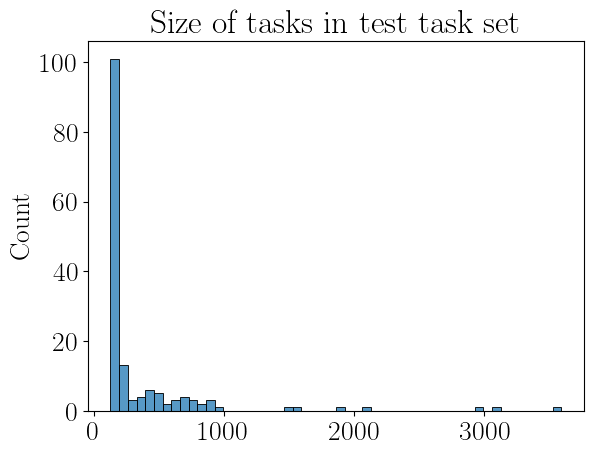

In [7]:
plt.figure()
sns.histplot(np.array(tasks_size))
plt.title('Size of tasks in test task set') 
plt.show()

In [8]:
task_id = 140
task = tasks[task_id]
print(len(task.samples))
print(type(task.samples[0]))

476
<class 'fs_mol.data.fsmol_task.MoleculeDatapoint'>


In [9]:
# The number of actives in each task:
actives = []
actives_size = []
for task in tasks:
    dummy = []
    for sample in task.samples:
        dummy.append(sample.bool_label)

    actives.append(np.array(dummy))
    actives_size.append(np.array(dummy).sum()/len(dummy))

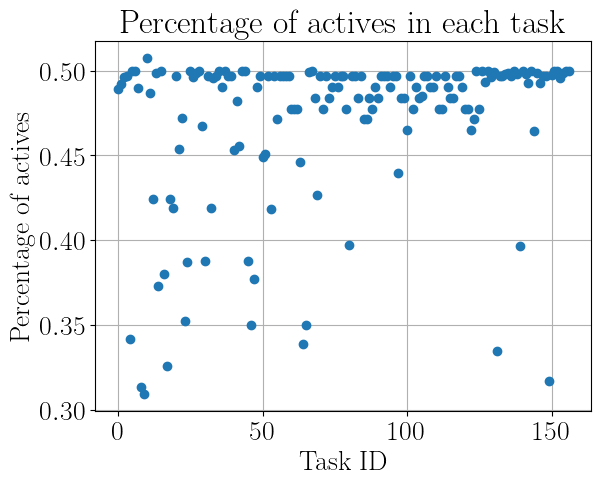

In [11]:
plt.figure()
plt.plot(actives_size, 'o')
plt.title('Percentage of actives in each task')
plt.xlabel('Task ID')
plt.ylabel('Percentage of actives') 
plt.grid()
plt.show()

In [12]:
from fs_mol.data import StratifiedTaskSampler
task_sampler = StratifiedTaskSampler(
    train_size_or_ratio = 16,
    valid_size_or_ratio = 0.0,
    test_size_or_ratio = 512, 
    allow_smaller_test = True
)

In [13]:
tasks_sample = [task_sampler.sample(task, seed=0) for task in tasks]

train_size: List = [len(task_sample.train_samples) for task_sample in tasks_sample]
test_size: List = [len(task_sample.test_samples) for task_sample in tasks_sample]



"""print(f"Number of samples in task: {len(task.samples)}")
print(f"Number of train samples: {len(task_sample.train_samples)}")
print(f"Number of test samples: {len(task_sample.test_samples)}")
print(f"Number of valid samples: {len(task_sample.valid_samples)}")"""

'print(f"Number of samples in task: {len(task.samples)}")\nprint(f"Number of train samples: {len(task_sample.train_samples)}")\nprint(f"Number of test samples: {len(task_sample.test_samples)}")\nprint(f"Number of valid samples: {len(task_sample.valid_samples)}")'

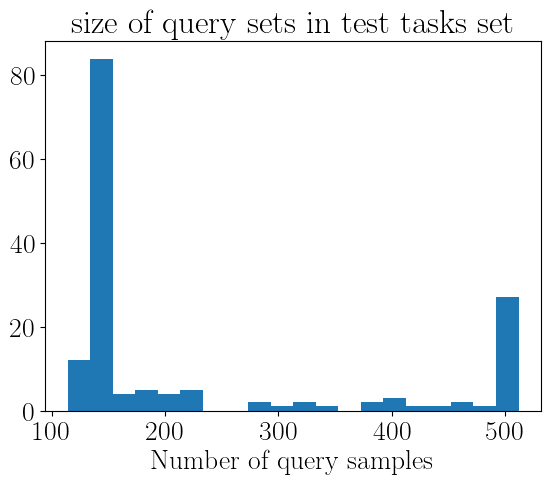

In [16]:
plt.hist(test_size, bins=20)
plt.title('size of query sets in test tasks set')
plt.xlabel('Number of query samples')
plt.show()

In [17]:
print(np.array(test_size).min())
print(np.array(test_size).max())
print(np.array(test_size).mean())

114
512
234.47770700636943


In [65]:
""" print(f'number of actives in Support set: {sum([mol.bool_label for mol in task_sample.train_samples])}')
print(f'percentage of actives in Support set: {sum([mol.bool_label for mol in task_sample.train_samples])/len(task_sample.train_samples)}')

print(f'number of actives in Query set: {sum([mol.bool_label for mol in task_sample.test_samples])}')
print(f'percentage of actives in Query set: {sum([mol.bool_label for mol in task_sample.test_samples])/len(task_sample.test_samples)}') """

" print(f'number of actives in Support set: {sum([mol.bool_label for mol in task_sample.train_samples])}')\nprint(f'percentage of actives in Support set: {sum([mol.bool_label for mol in task_sample.train_samples])/len(task_sample.train_samples)}')\n\nprint(f'number of actives in Query set: {sum([mol.bool_label for mol in task_sample.test_samples])}')\nprint(f'percentage of actives in Query set: {sum([mol.bool_label for mol in task_sample.test_samples])/len(task_sample.test_samples)}') "

In [18]:
from rdkit import Chem,DataStructs
import numpy as np
from collections import defaultdict
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
import rdkit
print(rdkit.__version__)

2022.03.2


In [19]:
sims_tasks: List[np.ndarray] = []
for task_sample in tasks_sample:
    sims = []
    for supp_mol in task_sample.train_samples:
        mol1 = Chem.MolFromSmiles(supp_mol.smiles)
        sim = []
        fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2, 2048) 

        for query_mol in task_sample.test_samples:
            mol2 = Chem.MolFromSmiles(query_mol.smiles)
            fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2, 2048)
            sim.append(DataStructs.TanimotoSimilarity(fp1,fp2))
        
        sims.append(sim)
    sims_tasks.append(np.array(sims))

In [20]:
print(len(sims_tasks))
print(sims_tasks[100].shape)

157
(16, 141)


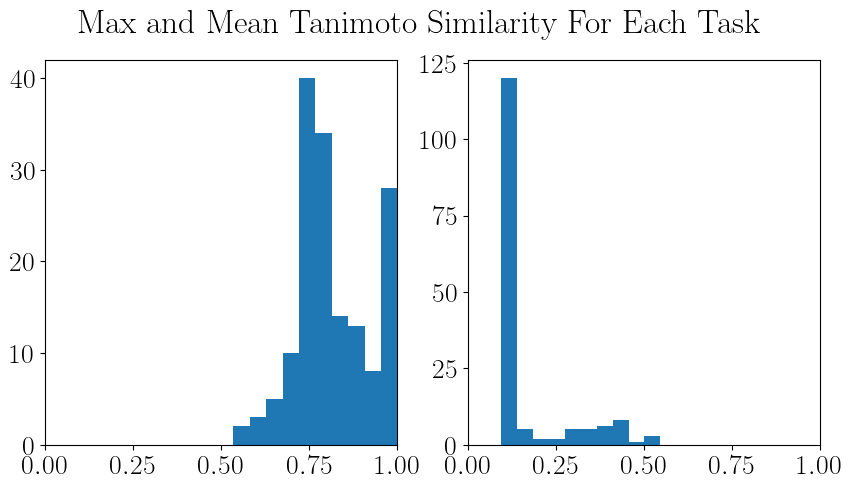

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Max and Mean Tanimoto Similarity For Each Task')
ax1.hist([sims_task.max() for sims_task in sims_tasks])
ax2.hist([sims_task.mean() for sims_task in sims_tasks])

ax1.set_xlim(0, 1)
ax2.set_xlim(0, 1)

plt.show()

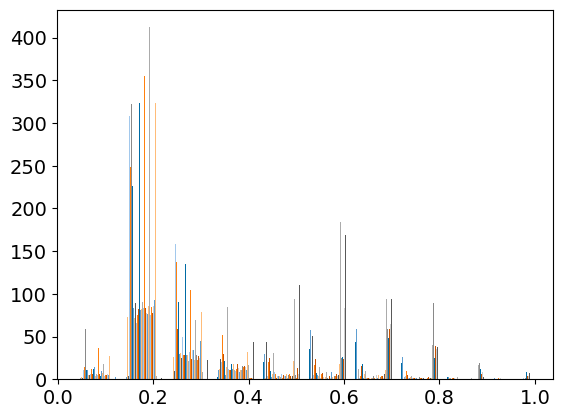

In [21]:
plt.hist([sims_task.max(axis=0) for sims_task in sims_tasks])
plt.show()

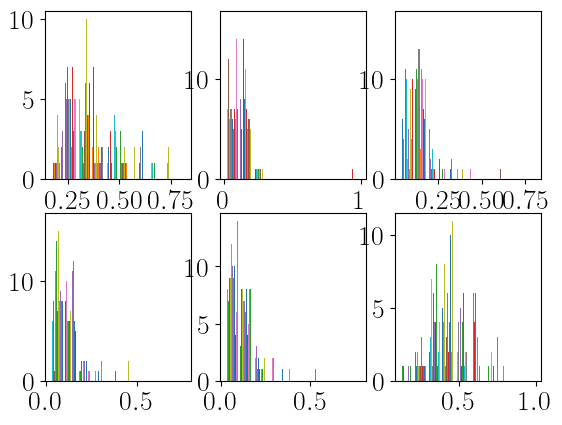

In [25]:
fig, ax = plt.subplots(2, 3)
ax[0][0].hist(sims_tasks[0])
ax[0][1].hist(sims_tasks[25])
ax[0][2].hist(sims_tasks[50])
ax[1][0].hist(sims_tasks[100])
ax[1][1].hist(sims_tasks[125])
ax[1][2].hist(sims_tasks[150])
plt.show()


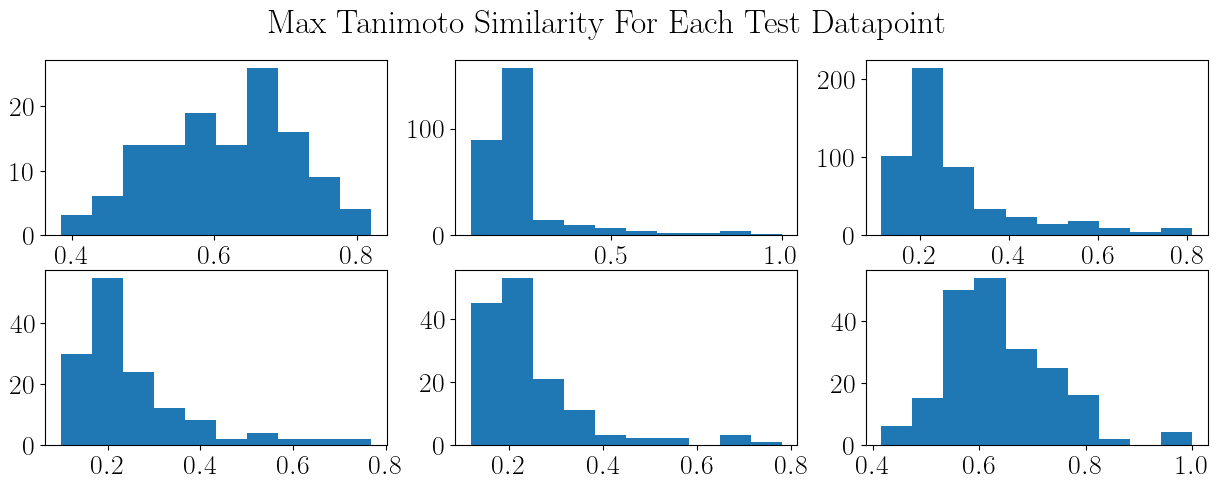

In [30]:
fig, ax = plt.subplots(2, 3, figsize=(15, 5))
fig.suptitle('Max Tanimoto Similarity For Each Test Datapoint')
ax[0][0].hist(sims_tasks[0].max(axis=0))
ax[0][1].hist(sims_tasks[25].max(axis=0))
ax[0][2].hist(sims_tasks[50].max(axis=0))
ax[1][0].hist(sims_tasks[100].max(axis=0))
ax[1][1].hist(sims_tasks[125].max(axis=0))
ax[1][2].hist(sims_tasks[150].max(axis=0))
plt.show()

In [31]:
thr = 0.5
similar_ind: List[np.ndarray] = [sims_task.max(axis=0) >= thr for sims_task in sims_tasks]
not_similar_ind: List[np.ndarray] = [np.logical_not(ind) for ind in similar_ind]
""" th1 = 0.4
th2 = 0.6
not_similar_ind = sims.max(axis=0) < th1
similar_ind = (sims.max(axis=0) >= th1) & (sims.max(axis=0) < th2)
very_similar_ind = sims.max(axis=0) >= th2 """

' th1 = 0.4\nth2 = 0.6\nnot_similar_ind = sims.max(axis=0) < th1\nsimilar_ind = (sims.max(axis=0) >= th1) & (sims.max(axis=0) < th2)\nvery_similar_ind = sims.max(axis=0) >= th2 '

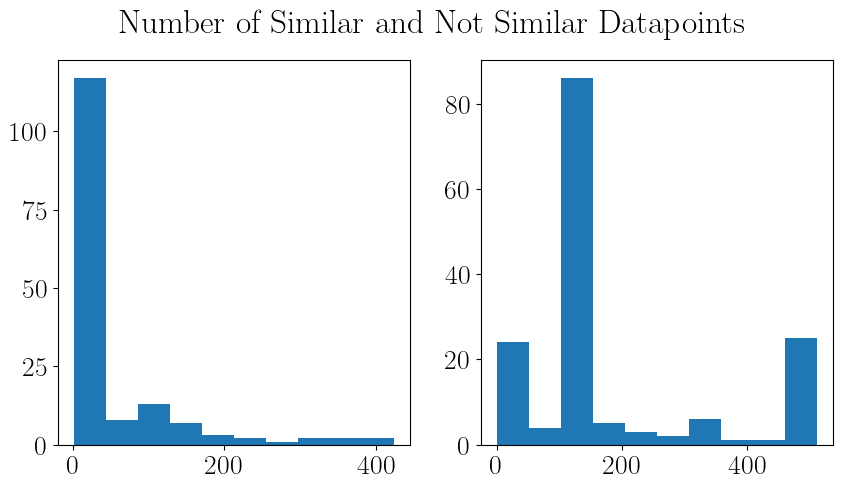

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Number of Similar and Not Similar Datapoints')
ax1.hist([ind.sum() for ind in similar_ind])
ax2.hist([ind.sum() for ind in not_similar_ind])
#ax2.hist([sim_ind.size - sim_ind.sum() for sim_ind in similar_ind])

plt.show()

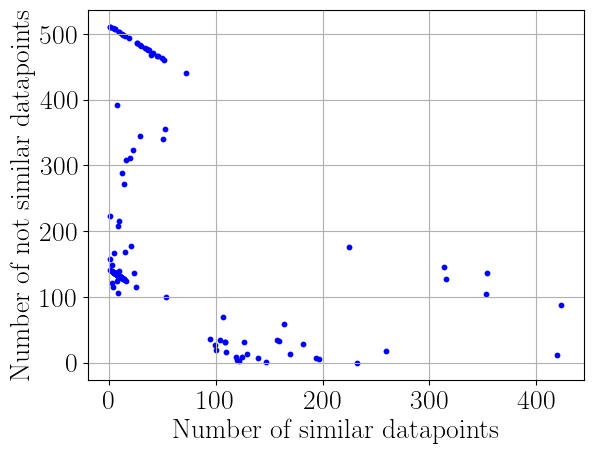

In [37]:
a = [ind.sum() for ind in similar_ind]
b = [ind.sum() for ind in not_similar_ind]
plt.scatter(a, b, s=10, c='b')
plt.xlabel('Number of similar datapoints')
plt.ylabel('Number of not similar datapoints')
plt.grid()

In [31]:
len(similar_ind)

157

In [48]:
from itertools import compress
a = list(compress(tasks_sample[0].test_samples, similar_ind[0]))

In [51]:
vars(a[0])

{'task_name': 'CHEMBL1066254',
 'smiles': 'CC(C)N(CCC(=O)c1ccccn1)Cc1ccccc1',
 'graph': GraphData(node_features=array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
       

In [ ]:
import jsonlines
output_path = os.path.join("/data/local/apps/", "Meta-Learning", "FS-Mol", "output.jsonl")
b = [vars(mol) for mol in a]
with jsonlines.open(output_path, mode='w') as writer:
    writer.write(b)

In [3]:
## Reading informations about targets
import pandas as pd
import os
train_proteins = pd.read_csv(os.path.join(FS_MOL_DATASET_PATH, "targets", "train_proteins.csv"))


In [5]:
from collections import Counter
Counter(train_proteins.confidence)

Counter({4: 125, 5: 139, 6: 82, 7: 184, 8: 1347, 9: 3061})